In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [2]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [3]:
# creating a table for sessions for mobile app users
# mobile app users are users where app version is NOT NULL
sql = '''
SELECT user_id, date("time") 
FROM heap.sessions
WHERE date("time") >= date(current_date - interval '28 days')
AND date("time") < date(current_date)
AND app_version IS NOT NULL
AND device_type <> 'Desktop'
'''
sessions = pd.read_sql_query(sql, con=engine)
sessions = sessions.rename(columns={'date': 'session_created_at', 'user_id': 'heap_user_id'})
sessions

,heap_user_id,session_created_at
0,5844184130904082,2021-01-08
1,2272951423325552,2021-01-08
2,1839926453430973,2021-01-08
3,8682997174573921,2021-01-08
4,2535686907143817,2021-01-08
...,...,...
944889,2271802379295980,2021-01-18
944890,8665607093762023,2021-01-18
944891,2941710130041552,2021-01-18
944892,2941710130041552,2021-01-18


In [4]:
sessions.describe(include='all')

,heap_user_id,session_created_at
count,9.448940e+05,944894
unique,NaN,28
top,NaN,2021-01-14
freq,NaN,57031
mean,4.429222e+15,NaN
std,2.568693e+15,NaN
min,2.620074e+11,NaN
25%,2.226824e+15,NaN
50%,4.376114e+15,NaN
75%,6.598188e+15,NaN


In [5]:
# creating a table for heap users
sql = '''
SELECT user_id, "identity", companies_name, company_id, company_name 
FROM heap.users
WHERE role NOT IN ('Dispatcher', 'Owner')
'''
heap_users = pd.read_sql_query(sql, con=engine)
heap_users = heap_users.rename(columns={'user_id': 'heap_user_id', 'identity': 'driver_guid',
                                        'company_id': 'company_guid'})
heap_users

,heap_user_id,driver_guid,companies_name,company_guid,company_name
0,6807024858885883,f6bb8ed9-6149-41b2-993b-e92b6af03cf1,Logitrans llc,9a98d372-5425-4d47-929a-01918932d763,Logitrans llc
1,2572887914923971,fe9235d4-3ddb-4b7f-91ce-b4caf535f535,PUSKAS TRUCKING INC,a776c65a-19e3-424d-a032-d9118dee1c52,PUSKAS TRUCKING INC
2,4080565631628748,d41884bd-3b7e-4f4d-b3f3-f8d055480594,Unlimited Car Carrier Inc.,None,None
3,2130327118247784,8343e4df-fd1a-4aff-8cb6-ba0afcb6cfa8,None,d841a787-cd06-42e2-967b-ab8c67e0b321,MILLENNIUM GROUP INC OF IL
4,5825757294889074,1ed54f0c-b6cd-461b-8e75-4928776de8b1,None,2addf6fe-f040-43f8-958b-87db96066ae4,SHAROF TRANS INC
...,...,...,...,...,...
41361,5549534364994307,35ae85e0-ddc7-4dfc-8f6b-6949acb726e0,None,None,None
41362,4297749781023503,1854a2af-c5a1-4e52-957c-09a3c63c0933,None,None,None
41363,7558701841488685,77da43e2-d647-4d21-a207-58638546d392,None,None,None
41364,2308935508139370,b8fcf12b-4d2e-45ed-8c57-f00e561645d8,None,None,None


In [6]:
heap_users.describe(include='all')

,heap_user_id,driver_guid,companies_name,company_guid,company_name
count,4.136600e+04,41366,18924,14752,14752
unique,NaN,41366,9885,9433,9355
top,NaN,2a89a201-c6c5-4b8b-97fc-fb103db4dd56,TRANSPORTING INVOICE,d0185a0a-6edb-470b-87bf-7573e0b24e28,Gig Logistics inc
freq,NaN,1,214,155,155
mean,4.487063e+15,NaN,NaN,NaN,NaN
std,2.602573e+15,NaN,NaN,NaN,NaN
min,1.109229e+12,NaN,NaN,NaN,NaN
25%,2.239623e+15,NaN,NaN,NaN,NaN
50%,4.465918e+15,NaN,NaN,NaN,NaN
75%,6.710382e+15,NaN,NaN,NaN,NaN


### Joining heap user table with heap sessions table

In [7]:
sessions1 = sessions.merge(heap_users, how='inner', left_on='heap_user_id', right_on='heap_user_id')
sessions1

,heap_user_id,session_created_at,driver_guid,companies_name,company_guid,company_name
0,5844184130904082,2021-01-08,99488ca1-d79d-4557-a79c-1b945761a6fa,None,07873e4d-234f-45d2-9095-803e0aff043a,J Trans Group Inc
1,5844184130904082,2021-01-08,99488ca1-d79d-4557-a79c-1b945761a6fa,None,07873e4d-234f-45d2-9095-803e0aff043a,J Trans Group Inc
2,5844184130904082,2021-01-08,99488ca1-d79d-4557-a79c-1b945761a6fa,None,07873e4d-234f-45d2-9095-803e0aff043a,J Trans Group Inc
3,5844184130904082,2021-01-08,99488ca1-d79d-4557-a79c-1b945761a6fa,None,07873e4d-234f-45d2-9095-803e0aff043a,J Trans Group Inc
4,5844184130904082,2021-01-08,99488ca1-d79d-4557-a79c-1b945761a6fa,None,07873e4d-234f-45d2-9095-803e0aff043a,J Trans Group Inc
...,...,...,...,...,...,...
655703,1472312169488227,2021-01-17,3b8ad876-f6e7-42b9-882f-d0527c3aa834,None,None,None
655704,1472312169488227,2021-01-17,3b8ad876-f6e7-42b9-882f-d0527c3aa834,None,None,None
655705,3455287098000141,2021-01-18,b07f203c-454a-4501-9b81-d255eeca8fd8,None,None,None
655706,7979038217388621,2021-01-17,dc03578b-9483-48ec-8e94-b2d312e68367,MURPHY HAULING LLC,8a149d6f-465b-410b-b8c0-62d714a74308,MURPHY HAULING LLC


In [8]:
sessions1.describe(include='all')

,heap_user_id,session_created_at,driver_guid,companies_name,company_guid,company_name
count,6.557080e+05,655708,655708,440138,303921,303921
unique,NaN,28,8360,3763,3232,3233
top,NaN,2021-01-14,d26a6952-8ec1-4e3e-a2d5-848d1e4c38ed,TRANSPORTING INVOICE,d0185a0a-6edb-470b-87bf-7573e0b24e28,Gig Logistics inc
freq,NaN,39557,2300,11633,3506,3506
mean,4.441707e+15,NaN,NaN,NaN,NaN,NaN
std,2.572884e+15,NaN,NaN,NaN,NaN,NaN
min,1.703780e+12,NaN,NaN,NaN,NaN,NaN
25%,2.224109e+15,NaN,NaN,NaN,NaN,NaN
50%,4.425793e+15,NaN,NaN,NaN,NaN,NaN
75%,6.614213e+15,NaN,NaN,NaN,NaN,NaN


In [9]:
sessions1.isna().sum()/sessions1.isna().count()

heap_user_id          0.000000
session_created_at    0.000000
driver_guid           0.000000
companies_name        0.328759
company_guid          0.536499
company_name          0.536499
dtype: float64

In [10]:
# creating a table of drivers to get driver guid
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid', 'genericuser_ptr_id': 'driver_id'})
drivers

,driver_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df
...,...,...,...
62973,84359,40915,a2ce78c9-52b3-48fe-91f4-5d2cd1b0a5d1
62974,84679,40996,3ef37760-55e5-43da-8d2c-c461f3ad1a41
62975,84960,37928,381eef52-a634-44f6-93f7-35a85f75ea74
62976,85358,2305,2c220ce5-1228-427f-8fde-b3e7c3ffd02e


In [11]:
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
WHERE test_account = False
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid', 'name': 'carrier_name'})
carriers

,carrier_name,carrier_id,carrier_guid
0,J&T Wrecker Service LLC,33,9e446db7-d3dd-443e-a16e-b9edf7685e05
1,Prime Track Inc,167,45c2d62f-50f8-464b-9d8b-289c22af3a8e
2,Real Deal Auto Clinic Inc.,171,4dfb1eea-8eed-4156-9924-9776a2b0b6f0
3,AS trucking llc,211,f2584277-d577-430f-932a-003254a6fdcc
4,FM Auto trans,229,ef862060-9260-4204-863c-259bdc74a8f4
...,...,...,...
40891,Autotrans LLC,21214,d8d4f6c9-a3a8-42c7-a263-96ab519986b5
40892,Prym Transportation Services Ltd,24332,6cdfb609-fb0c-4284-9652-1e17482b9b7d
40893,H&M'S TRANSPORTATION LTD,30463,b4d67709-2f73-442e-a24f-95240148a773
40894,LJ's Towing And Transport,33518,339ab5c2-68ef-42a0-acc9-7c260bdd1407


In [12]:
drivers.describe(include='all')

,driver_id,carrier_id,driver_guid
count,62978.000000,62978.000000,62978
unique,NaN,NaN,62978
top,NaN,NaN,2a89a201-c6c5-4b8b-97fc-fb103db4dd56
freq,NaN,NaN,1
mean,41089.727810,21373.579742,NaN
std,24947.693383,13041.930573,NaN
min,6.000000,3.000000,NaN
25%,19043.250000,9072.000000,NaN
50%,40169.500000,22154.500000,NaN
75%,62053.750000,32364.500000,NaN


In [13]:
drivers_with_carrier_guid = drivers.merge(carriers, left_on='carrier_id', right_on='carrier_id')
drivers_with_carrier_guid

,driver_id,carrier_id,driver_guid,carrier_name,carrier_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
1,219,20,92db1d6c-f2ba-4fd9-b59d-f590fa17863f,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
2,6698,20,850ea758-e571-4401-974d-af97e562c378,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
3,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d,Rum Runners Auto Transport,ad6b963f-0a4a-4b71-b643-eed8e713afce
4,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0,Alt & Son Corp.,2271da16-eca1-48d6-8b67-9eeecdd6bd14
...,...,...,...,...,...
62226,76832,41083,e6a63309-dc3e-415e-bea6-610ab0127131,MACIAS & MACIAS TRANSPORT LLC,65cf2d41-29a2-4489-b5ee-8fe908697152
62227,79531,42039,c12bfb9c-a383-433d-98e3-79bd4b0a315c,MJ DELIVERIES,dbf463f4-287c-4107-8a73-165cd92e912a
62228,80344,42354,c56be0c9-00bb-4cfc-8c69-e830171c0e0f,HYPER EXPRESS LLC,168fdd4d-2b86-41f9-ba57-e9b65e2c7beb
62229,84776,44078,fa2bfa7d-4d78-4c0b-ab54-da4817be1c4e,FRANKY TRANSPORTATION,569e01f3-1337-4578-ab5c-41b7ea1ab274


In [14]:
sessions2 = sessions1.merge(drivers_with_carrier_guid, left_on='driver_guid', right_on='driver_guid')
result = sessions2.groupby(['driver_id', 'driver_guid']).nunique()
result.reset_index(inplace=True)
result = result.rename(columns={'session_created_at': 'unique_days_opening_app'})
result

,driver_id,driver_guid,heap_user_id,unique_days_opening_app,companies_name,company_guid,company_name,carrier_id,carrier_name,carrier_guid
0,145,a705dfef-bd67-45d4-91cd-648673fade63,1,12,1,0,0,1,1,1
1,154,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,1,5,1,1,1,1,1,1
2,174,27abbc41-fa85-46c9-9545-418a2fd2d05a,1,6,1,1,1,1,1,1
3,175,95b49d52-c6bb-4ff1-afb0-ab58b9708970,1,20,1,1,1,1,1,1
4,186,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,1,27,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
7836,85509,6520d48c-c378-45d7-8404-bd2bee471347,1,2,0,0,0,1,1,1
7837,85526,c38ba762-5578-43aa-a616-a00e159ee206,1,3,0,0,0,1,1,1
7838,85528,77da43e2-d647-4d21-a207-58638546d392,1,2,0,0,0,1,1,1
7839,85531,b8fcf12b-4d2e-45ed-8c57-f00e561645d8,1,4,0,0,0,1,1,1


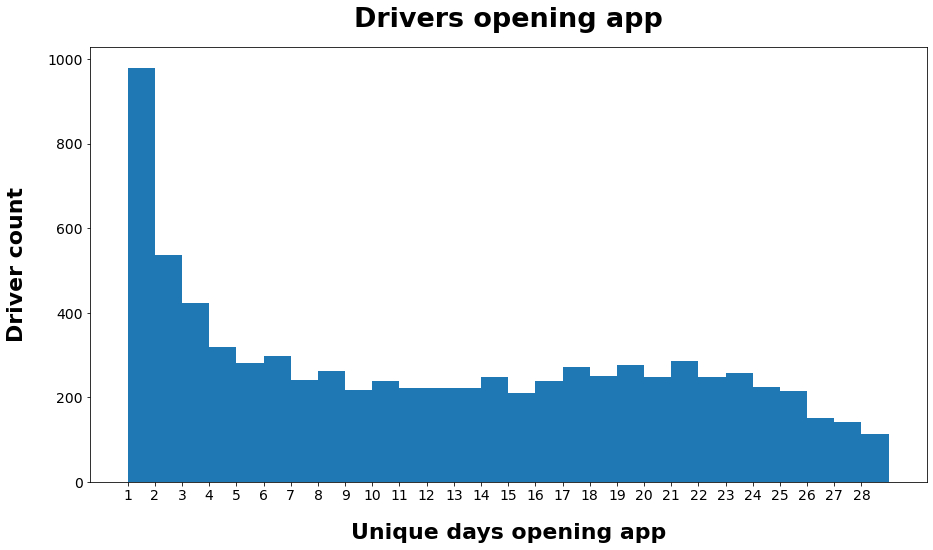

In [15]:
# histogram of unique accepted offers in last 28 days (all carriers)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_opening_app'], bins=np.arange(1, 30))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days opening app', fontsize=22, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=22, fontweight='bold', labelpad=20)
plt.title('Drivers opening app', fontsize=27, fontweight='bold', pad=20)
plt.show()

In [16]:
total_drivers_for_days_active = []

for i in range(1,29):
    active_driver_count = (result[result['unique_days_opening_app'] >= i].groupby('unique_days_opening_app').count()
                           ['driver_guid'].sum())
    
    total_drivers_for_days_active.append(active_driver_count)

In [17]:
active_drivers = pd.DataFrame()
active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
active_drivers['total_drivers_at_least_this_active'] = total_drivers_for_days_active
active_drivers['total_percentage_active'] = round(100*active_drivers['total_drivers_at_least_this_active']/len(result))
active_drivers['total_percentage_dormant'] = 100 - active_drivers['total_percentage_active']

In [18]:
def plot(metric_definition):
    plt.figure(figsize=(13,13))
    graph = sns.barplot(x=['active', 'dormant'],
                        y=[active_drivers.loc[metric_definition, 'total_drivers_at_least_this_active'],
                           (active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            active_drivers.loc[metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in graph.patches:
        graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        graph.annotate('{}%'.format(round(100*p.get_height()/active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=22, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
    opening app was our metric'''.format(metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

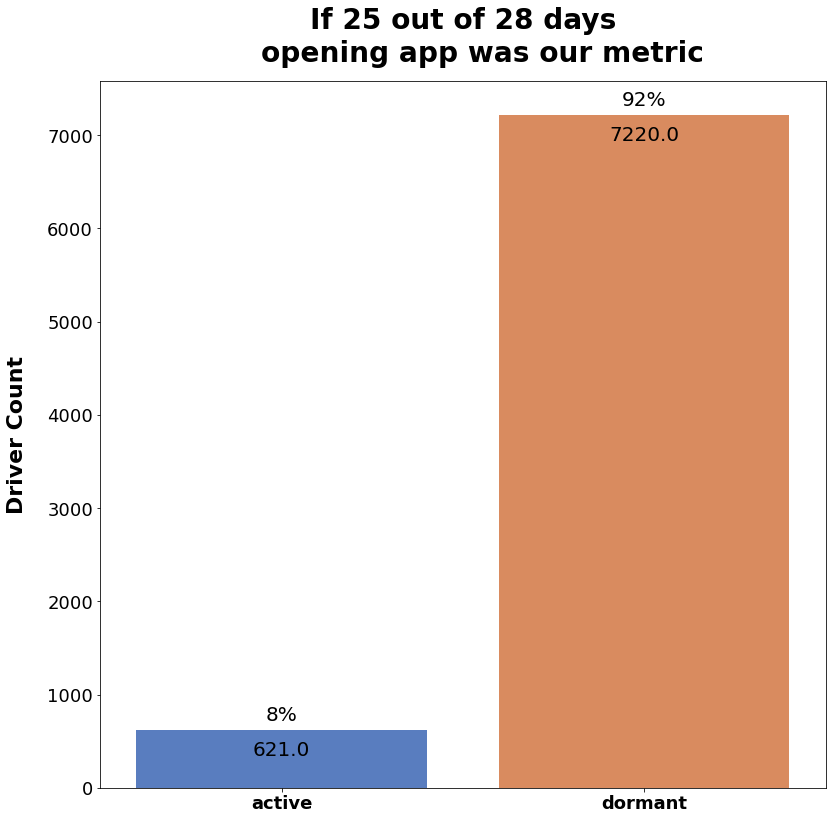

In [19]:
plot(25)

# Now let's segment paid users and free users

In [20]:
# creating a table for braintree subscriptions
sql = '''
DROP TABLE IF EXISTS #carrier_with_latest_sub_date
;
SELECT 
carrier_id
,max(created_at) AS last_sub
INTO #carrier_with_latest_sub_date
FROM ctms_db_public.billing_braintreesubscription
WHERE braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
GROUP BY carrier_id
;
SELECT 
#carrier_with_latest_sub_date.carrier_id
,last_sub
,braintree_subscription_status
FROM #carrier_with_latest_sub_date
JOIN ctms_db_public.billing_braintreesubscription
ON #carrier_with_latest_sub_date.carrier_id = billing_braintreesubscription.carrier_id
AND #carrier_with_latest_sub_date.last_sub = billing_braintreesubscription.created_at
WHERE billing_braintreesubscription.braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
;
'''
braintree_subs = pd.read_sql_query(sql, con=engine)
braintree_subs

,carrier_id,last_sub,braintree_subscription_status
0,2978,2016-11-26 09:21:34.937541,Active
1,5164,2017-01-05 22:15:51.921429,Active
2,3109,2016-11-26 09:21:33.283626,Active
3,8280,2017-06-17 15:20:29.527819,Active
4,831,2016-11-26 09:21:32.012823,Active
...,...,...,...
2866,4116,2021-01-18 20:57:54.743970,Active
2867,41286,2020-11-05 22:06:52.942985,Active
2868,36837,2021-01-18 20:43:32.137428,Active
2869,5659,2021-01-18 21:08:43.603265,Active


In [21]:
# creating a carriers table
sql = '''
SELECT name, id, guid
FROM ctms_db_public.msd_carrier
WHERE test_account = False
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid'})
carriers

,name,carrier_id,carrier_guid
0,J&T Wrecker Service LLC,33,9e446db7-d3dd-443e-a16e-b9edf7685e05
1,Prime Track Inc,167,45c2d62f-50f8-464b-9d8b-289c22af3a8e
2,Real Deal Auto Clinic Inc.,171,4dfb1eea-8eed-4156-9924-9776a2b0b6f0
3,AS trucking llc,211,f2584277-d577-430f-932a-003254a6fdcc
4,FM Auto trans,229,ef862060-9260-4204-863c-259bdc74a8f4
...,...,...,...
40891,FINISH LINE RACING TRANSPORT LLC,43695,3e63fc3b-a64d-4a82-91bb-3e0dd230b34b
40892,Rainier Trucking LLC.,14050,d96272b4-3f12-4e9f-8fc3-bc9e92848331
40893,ROLLIN ENTERPRISES INCORPORATED,29525,b552be0b-fba4-4771-9e90-48cbabcf44eb
40894,UZ Auto Trans Inc,166,3da07a51-afb4-4efe-8be0-29a823c2fc8f


In [22]:
# joining carriers with braintree table

braintree_with_carriers = braintree_subs.merge(carriers, left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers
paid_carriers = braintree_with_carriers
paid_carriers

,carrier_id,last_sub,braintree_subscription_status,name,carrier_guid
0,2978,2016-11-26 09:21:34.937541,Active,AU-THENTIC INDUSTRIES LLC,1e1366e5-0c67-4019-bd33-e255416c7df7
1,5164,2017-01-05 22:15:51.921429,Active,Capital Trucking LLC,255749b3-8b17-421a-a3ed-353ca3472495
2,3109,2016-11-26 09:21:33.283626,Active,MEI Transportation Services Inc,49cdf08d-56ea-48c6-87d1-91515bf31639
3,8280,2017-06-17 15:20:29.527819,Active,ZPA Incorporated,ba962dbd-1e32-4caf-83e9-59db46983d6a
4,831,2016-11-26 09:21:32.012823,Active,Born Again Hauling,6f3b99e9-ad63-4ca1-abae-44b6c7cd0a14
...,...,...,...,...,...
2866,4116,2021-01-18 20:57:54.743970,Active,Vyrado Logistics LLC,ac64fd07-9018-4be7-9c81-fef79f47fbb6
2867,41286,2020-11-05 22:06:52.942985,Active,JVM AUTO TRANSPORT LLC,449569cb-5171-4351-8e9c-25ad36f196e6
2868,36837,2021-01-18 20:43:32.137428,Active,YR AUTO SALES LLC,ef227962-d8f0-4a6f-a60f-b9d97c58ceec
2869,5659,2021-01-18 21:08:43.603265,Active,G'S Auto Hauling Inc,a1ef241d-81d3-47c0-91ec-2ce30e79642a


In [23]:
paid_drivers = drivers.merge(paid_carriers, left_on='carrier_id', right_on='carrier_id')
paid_drivers

,driver_id,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,782,361,385501a9-2116-415c-8698-cc380c6830cb,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
1,781,361,1c1503e2-a908-48f4-a880-ed528efd3b12,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
2,10352,361,e98aca37-2003-4a02-b4f6-76ba9061849b,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
3,4032,361,370aff85-faa5-4a65-a921-08ce62f1bfda,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
4,11663,361,eb3c0740-972a-47b6-a922-048184bbe962,2020-09-19 01:11:30.442133,Active,Big Boy Transporting & Towing,63d3ff59-538a-4f6a-a123-880f10830dfd
...,...,...,...,...,...,...,...
12142,7410,4347,c47914ad-5a86-416b-8f24-e1d413fe02f0,2016-11-26 09:21:34.350835,Active,G & D Trucking of Illinois Inc.,f8bc0c21-3b78-4913-804c-f78f04f3ca46
12143,34017,23172,59badc3d-7f65-49d2-8934-85e5d1f555f3,2018-12-25 18:16:44.657729,Active,STANDARD TOWING & TRANSPORT,f6ebd6f5-ebfa-42f8-9849-1235aef3ee11
12144,42299,27544,a0007ed8-ed8a-40a6-a18f-ca19342a97ae,2019-06-11 17:29:42.565170,Active,PERFECT TIMING TOWING,a0315d89-0730-4a71-8ee9-43e2c568dabc
12145,56652,34459,4044b68d-cf05-497f-998f-71c75cb988eb,2020-01-15 21:06:37.672882,Active,AUTOGREEN INC,09594ef3-e1dc-4f52-87f5-da0515b8dbb3


In [24]:
free_drivers = drivers.merge(paid_carriers, how='left', left_on='carrier_id', right_on='carrier_id')
# getting all free users
non_payers = free_drivers['braintree_subscription_status'].isna() == True
#dropping all rows with paid users
free_drivers = free_drivers[non_payers]
free_drivers

,driver_id,carrier_id,driver_guid,last_sub,braintree_subscription_status,name,carrier_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4,NaT,NaN,NaN,NaN
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d,NaT,NaN,NaN,NaN
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0,NaT,NaN,NaN,NaN
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347,NaT,NaN,NaN,NaN
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
62962,80946,38749,3402310c-7fad-42cb-bbc3-0485023c9e51,NaT,NaN,NaN,NaN
62965,84148,335,a2a9bffd-dc33-4411-9d13-f748aaca8a13,NaT,NaN,NaN,NaN
62967,84776,44078,fa2bfa7d-4d78-4c0b-ab54-da4817be1c4e,NaT,NaN,NaN,NaN
62970,85760,33856,eec1309f-341a-4120-b3f3-c83fb1e8c76f,NaT,NaN,NaN,NaN


# Paid users

In [25]:
sessions_paid_users = sessions2.merge(braintree_with_carriers, left_on='carrier_guid', right_on='carrier_guid')
result_paid_users = sessions_paid_users.groupby(['driver_id', 'driver_guid']).nunique()
result_paid_users.reset_index(inplace=True)
result_paid_users = result_paid_users.rename(columns={'session_created_at': 'unique_days_opening_app'})
result_paid_users

,driver_id,driver_guid,heap_user_id,unique_days_opening_app,companies_name,company_guid,company_name,carrier_id_x,carrier_name,carrier_guid,carrier_id_y,last_sub,braintree_subscription_status,name
0,145,a705dfef-bd67-45d4-91cd-648673fade63,1,12,1,0,0,1,1,1,1,1,1,1
1,267,47f61b55-dfc4-4f22-b140-01f3c1dd27bf,1,22,1,1,1,1,1,1,1,1,1,1
2,428,c5bf4b94-0b5a-4d6c-a6be-603ee1f215a4,1,15,1,1,1,1,1,1,1,1,1,1
3,634,787b5d1f-2f7e-438c-89d2-d3c3e90d6e06,1,7,1,0,0,1,1,1,1,1,1,1
4,656,395feda3-ecb2-4415-9be5-ab013576bc33,1,23,1,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,85336,38974122-6fad-4831-82ca-83e7b4341270,1,5,0,0,0,1,1,1,1,1,1,1
3753,85391,4588380c-42b2-4a3a-8c02-34e09c4eeb8b,1,4,0,0,0,1,1,1,1,1,1,1
3754,85434,1854a2af-c5a1-4e52-957c-09a3c63c0933,1,5,0,0,0,1,1,1,1,1,1,1
3755,85526,c38ba762-5578-43aa-a616-a00e159ee206,1,3,0,0,0,1,1,1,1,1,1,1


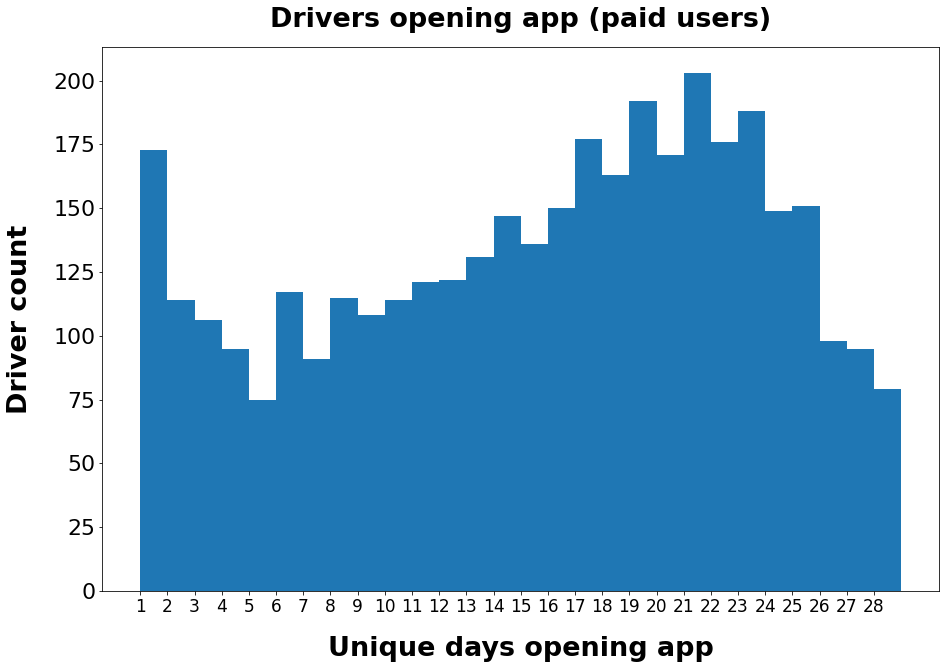

In [26]:
# histogram of unique accepted offers in last 28 days (paid carriers)
plt.figure(figsize=(15,10))
plt.hist(result_paid_users['unique_days_opening_app'], bins=np.arange(1, 30))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days opening app', fontsize=27, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=27, fontweight='bold', labelpad=20)
plt.title('Drivers opening app (paid users)', fontsize=27, fontweight='bold', pad=20)
plt.show()

# Free users

In [27]:
sessions_non_paid_users = sessions2.merge(braintree_with_carriers, how='left', left_on='carrier_guid', right_on='carrier_guid')
# free users
non_payers = sessions_non_paid_users['braintree_subscription_status'].isna() == True
# dropping all paid user rows
sessions_non_paid_users = sessions_non_paid_users[non_payers]
result_non_paid_users = sessions_non_paid_users.groupby(['driver_id', 'driver_guid']).nunique()
result_non_paid_users.reset_index(inplace=True)
result_non_paid_users = result_non_paid_users.rename(columns={'session_created_at': 'unique_days_opening_app'})
result_non_paid_users

,driver_id,driver_guid,heap_user_id,unique_days_opening_app,companies_name,company_guid,company_name,carrier_id_x,carrier_name,carrier_guid,carrier_id_y,last_sub,braintree_subscription_status,name
0,154,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,1,5,1,1,1,1,1,1,0,0,0,0
1,174,27abbc41-fa85-46c9-9545-418a2fd2d05a,1,6,1,1,1,1,1,1,0,0,0,0
2,175,95b49d52-c6bb-4ff1-afb0-ab58b9708970,1,20,1,1,1,1,1,1,0,0,0,0
3,186,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,1,27,1,1,1,1,1,1,0,0,0,0
4,213,733216f1-6987-4c63-9cb6-14189c9b8b43,1,8,1,1,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,85404,178d6292-3893-421e-b01f-ca461005ee25,1,1,0,0,0,1,1,1,0,0,0,0
4080,85462,b4fe05a6-a513-434c-a2e4-9f5fa2b61c6b,1,3,0,0,0,1,1,1,0,0,0,0
4081,85509,6520d48c-c378-45d7-8404-bd2bee471347,1,2,0,0,0,1,1,1,0,0,0,0
4082,85528,77da43e2-d647-4d21-a207-58638546d392,1,2,0,0,0,1,1,1,0,0,0,0


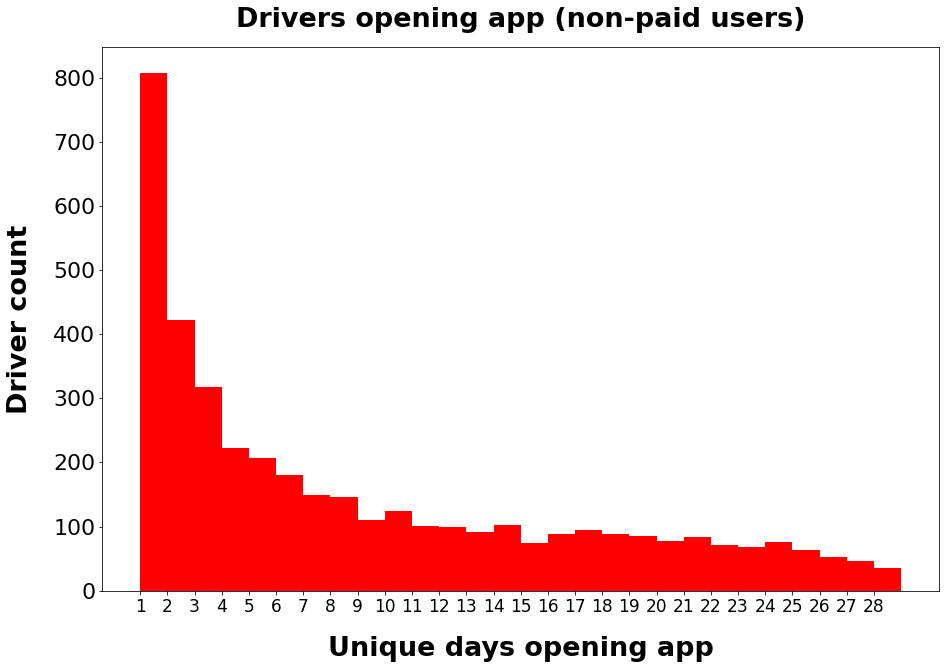

In [28]:
# histogram of unique accepted offers in last 28 days (all carriers)
plt.figure(figsize=(15,10))
plt.hist(result_non_paid_users['unique_days_opening_app'], bins=np.arange(1, 30), color='red')
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=22)
plt.xlabel('Unique days opening app', fontsize=27, fontweight='bold', labelpad=20)
plt.ylabel('Driver count', fontsize=27, fontweight='bold', labelpad=20)
plt.title('Drivers opening app (non-paid users)', fontsize=27, fontweight='bold', pad=20)
plt.show()

In [29]:
total_paid_drivers_for_days_active = []

for i in range(1,29):
    paid_active_driver_count = (result_paid_users[result_paid_users['unique_days_opening_app'] >= i]
                           .groupby('unique_days_opening_app').count()['driver_guid'].sum())
    
    total_paid_drivers_for_days_active.append(paid_active_driver_count)
    


total_non_paid_drivers_for_days_active = []

for i in range(1,29):
    non_paid_active_driver_count = (result_non_paid_users[result_non_paid_users['unique_days_opening_app'] >= i]
                           .groupby('unique_days_opening_app').count()['driver_guid'].sum())
    
    total_non_paid_drivers_for_days_active.append(non_paid_active_driver_count)

In [30]:
paid_active_drivers = pd.DataFrame()
paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_drivers['total_drivers_at_least_this_active'] = total_paid_drivers_for_days_active
paid_active_drivers['total_percentage_active'] = round(100*paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(result_paid_users))
paid_active_drivers['total_percentage_dormant'] = 100 - paid_active_drivers['total_percentage_active']


non_paid_active_drivers = pd.DataFrame()
non_paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
non_paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
non_paid_active_drivers['total_drivers_at_least_this_active'] = total_non_paid_drivers_for_days_active
non_paid_active_drivers['total_percentage_active'] = round(100*non_paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(result_non_paid_users))
non_paid_active_drivers['total_percentage_dormant'] = 100 - non_paid_active_drivers['total_percentage_active']

In [31]:
def metric_users(paid_metric_definition, non_paid_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'],
                           (paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
opening app
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[non_paid_active_drivers.loc[non_paid_metric_definition, 'total_drivers_at_least_this_active'],
                           (non_paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'] - 
                            non_paid_active_drivers.loc[non_paid_metric_definition, 'total_drivers_at_least_this_active'])],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/non_paid_active_drivers.loc[1, 'total_drivers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
opening app
(non-paid users)'''.format(non_paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

# Active users based on definition of metric
### Left side = Paid users
### Right side = Free users
### Our qualitative hypothesis was that a driver would open the app 16 out of 28 days.

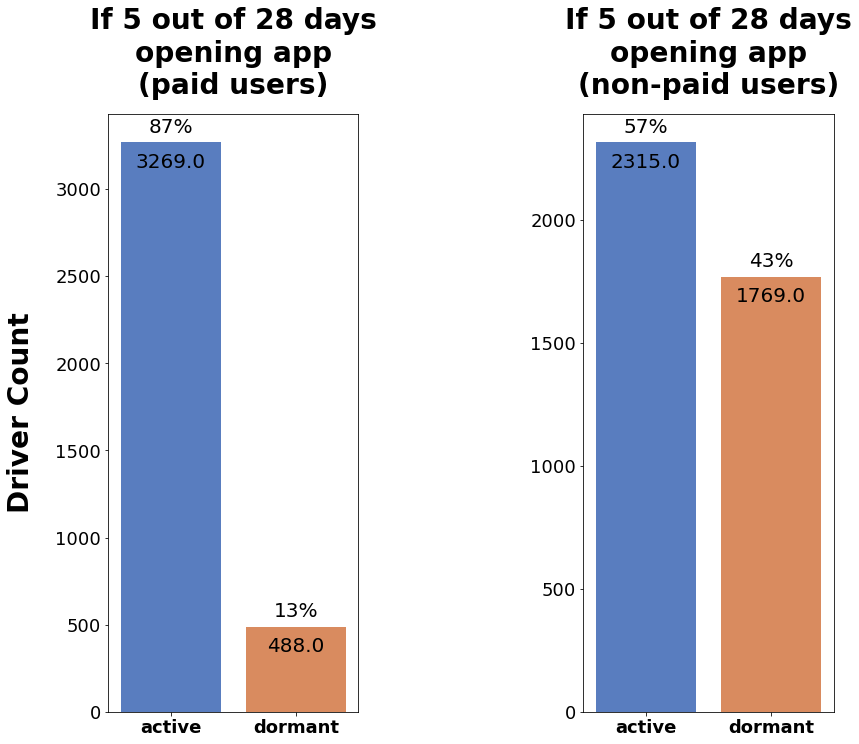

In [32]:
metric_users(5, 5)

In [33]:
paid_active_drivers = pd.DataFrame()
paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_drivers['total_drivers_at_least_this_active'] = total_paid_drivers_for_days_active
paid_active_drivers['total_dormant_drivers'] = ([len(paid_drivers) - total_paid_drivers_for_days_active[x]
                                                 for x in range(len(total_paid_drivers_for_days_active))])
paid_active_drivers['total_percentage_active'] = round(100*paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(paid_drivers))
paid_active_drivers['total_percentage_dormant'] = 100 - paid_active_drivers['total_percentage_active']

non_paid_active_drivers = pd.DataFrame()
non_paid_active_drivers['definition_is_this_many_days_active'] = np.arange(1,29)
non_paid_active_drivers.set_index('definition_is_this_many_days_active', inplace=True)
non_paid_active_drivers['total_drivers_at_least_this_active'] = total_non_paid_drivers_for_days_active
non_paid_active_drivers['total_dormant_drivers'] = ([len(free_drivers) - total_non_paid_drivers_for_days_active[x]
                                                 for x in range(len(total_non_paid_drivers_for_days_active))])
non_paid_active_drivers['total_percentage_active'] = round(100*non_paid_active_drivers['total_drivers_at_least_this_active']
                                                       /len(free_drivers))
non_paid_active_drivers['total_percentage_dormant'] = 100 - non_paid_active_drivers['total_percentage_active']

In [34]:
def all_users(paid_metric_definition, non_paid_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_drivers.loc[paid_metric_definition, 'total_drivers_at_least_this_active'],
                           paid_active_drivers.loc[paid_metric_definition, 'total_dormant_drivers']],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(paid_drivers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Driver Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
opening app
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[non_paid_active_drivers.loc[non_paid_metric_definition, 'total_drivers_at_least_this_active'], 
                           non_paid_active_drivers.loc[non_paid_metric_definition, 'total_dormant_drivers']],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(free_drivers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
opening app
(free users)'''.format(non_paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

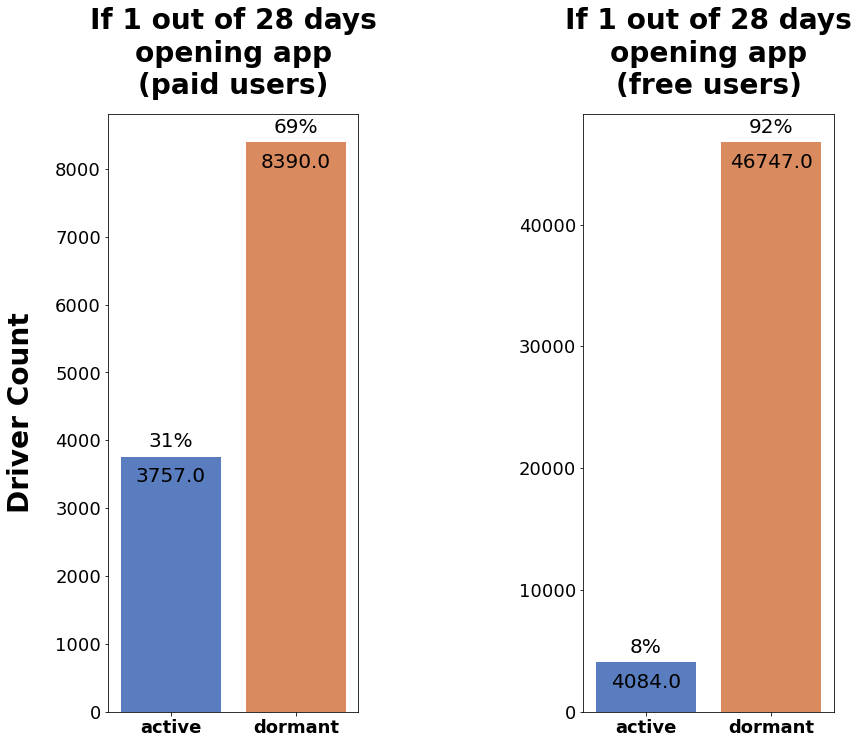

In [37]:
all_users(1, 1)